In [125]:
import random

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

# Option Valuation Methods - Homework 2
### Andrei Stefan


## Exercise 1: Implied volatility

#### 1a)

In [126]:
data = pd.DataFrame({'Exercise Price': [5125,5225,5325,5425,5525, 5625,5725, 5825],'Option Price': [485,415,350,290.5,236,189.5,149,115],})
T = 4/12
r=0.05
t=0
S = 5420.3
data

,Exercise Price,Option Price
0,5125,485.0
1,5225,415.0
2,5325,350.0
3,5425,290.5
4,5525,236.0
5,5625,189.5
6,5725,149.0
7,5825,115.0


In [127]:
def put_call_value(S, E, r, tau, sigma, option_type='call'):
    """
    Calculate the value of a call or put option using the Black-Scholes formula.
    :param S: Asset price at time t
    :param E: Exercise price
    :param r: interest rate
    :param tau: time to expiry (T-t)
    :param sigma: volatility
    :param option_type: 'call' or 'put'
    :return: option value, delta, and vega
    """
    if tau > 0:
        d1 = (np.log(S / E) + (r +0.5* sigma ** 2) * tau) / (sigma * np.sqrt(tau))
        d2 = d1 - sigma * np.sqrt(tau)
        # if option_type == 'call':
        value = S * stats.norm.cdf(d1) - E * np.exp(-r * tau) * stats.norm.cdf(d2)
        delta= stats.norm.cdf(d1)
        vega = S * np.sqrt(tau) * stats.norm.pdf(d1)
        # else:
        #     value = E * np.exp(-r * tau) * stats.norm.cdf(-d2) - S * stats.norm.cdf(-d1)
        #     delta = -stats.norm.cdf(-d1)
        #     vega = S * np.sqrt(tau) * np.exp(-d1 ** 2 / 2) / np.sqrt(2 * np.pi)
        return value, delta, vega
    else:
        if option_type == 'call':
            return max(S - E, 0), 1 if S > E else 0,0
        else:
            return max(E - S, 0), -1 if S < E else 0,0

In [128]:
def newtons_method_volatility(S, E, r, tau, C_true, tol=1e-6, max_iter=100):
    """
    Calculate the implied volatility of an option using Newton's method.
    :param S: Asset price at time t
    :param E:  Exercise price
    :param r: interest rate
    :param tau: time to expiry (T-t)
    :param C_true: true option price
    :param tol: tolerance
    :param max_iter: maximum number of iterations
    :return: implied volatility
    """
    # initial guess for volatility
    sigmahat = np.sqrt(2*abs((np.log(S/E) + r*tau)/tau))

    sigma = sigmahat
    sigmadiff = 1
    k=1
    while sigmadiff >= tol and k < max_iter:
        C, delta, vega = put_call_value(S, E, r, tau, sigma)
        vega = max(vega, 1e-6)
        increment = (C-C_true)/vega

        sigma = sigma - np.clip(increment,-0.5,0.5)
        sigmadiff = abs(increment)
        k += 1
    return sigma

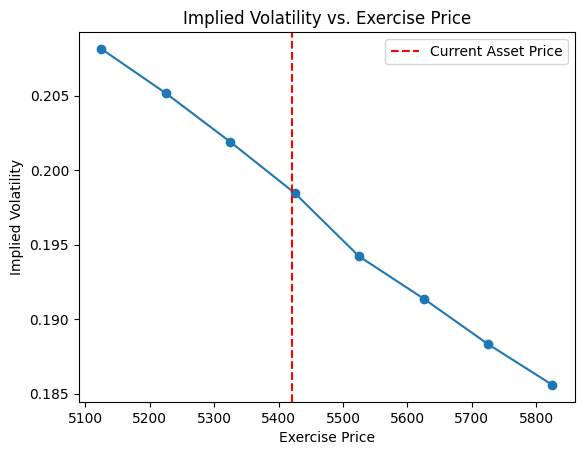

In [129]:
imp_volatilities = []
for i in range(len(data)):
    E = data['Exercise Price'][i]
    C_true = data['Option Price'][i]
    #call_BS = put_call_value(S, E, r, T, 0.2, option_type='call')
    #print(call_BS)
    implied_volatility = newtons_method_volatility(S, E, r, T, C_true)
    imp_volatilities.append(implied_volatility)

# print(imp_volatilities)

plt.plot(data['Exercise Price'], imp_volatilities, 'o-')
# vertical line with the current asset price S
plt.axvline(x=S, color='r', linestyle='--', label='Current Asset Price')

plt.xlabel('Exercise Price')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility vs. Exercise Price')
plt.legend()
plt.show()

#### 1b)

A for `$AAPL`

##### 1. fetching data (via barchart.com)

In [130]:
AAPL_17_01 = pd.read_csv('data/aapl-options-exp-2025-01-17.csv')
AAPL_24_01 = pd.read_csv('data/aapl-options-exp-2025-01-24.csv')
AAPL_17_10 = pd.read_csv('data/aapl-options-exp-2025-10-17.csv')
AAPL_18_06_26 = pd.read_csv('data/aapl-options-exp-2026-06-18.csv')
print(AAPL_17_01.head())
print(AAPL_24_01.head())

   Strike Moneyness    Bid    Mid    Ask   Last Change     %Chg Volume  \
0  212.50   +10.28%  24.25  24.93  25.60  24.95  -5.18  -17.19%     41   
1  215.00    +9.23%  21.90  22.23  22.55  21.35  -6.30  -22.78%    220   
2  217.50    +8.17%  18.75  19.75  20.75  25.34   unch     unch      0   
3  220.00    +7.11%  17.00  17.30  17.60  17.30  -5.85  -25.27%  1,667   
4  222.50    +6.06%  14.35  15.05  15.75  14.30  -6.55  -31.41%     48   

  Open Int OI Chg    Delta      IV  Type Last Trade  
0        1     +1  0.93882  56.39%  Call   01/10/25  
1   23,386    -45  0.95776  44.77%  Call   01/10/25  
2        4     +4  0.95075  41.18%  Call   01/08/25  
3   36,713    -48  0.93910  38.12%  Call   01/10/25  
4       40    +15  0.90178  38.87%  Call   01/10/25  
   Strike Moneyness    Bid    Mid    Ask   Last Change     %Chg Volume  \
0  212.50   +10.28%  23.05  24.90  26.75  25.50   unch     unch      2   
1  215.00    +9.23%  22.10  22.78  23.45  22.80  -4.78  -17.33%     17   
2  217.50

In [131]:
# Filter call options correctly using .loc
AAPL_calls_17_01 = AAPL_17_01.loc[AAPL_17_01['Type'] == 'Call'].copy()
AAPL_calls_24_01 = AAPL_24_01.loc[AAPL_24_01['Type'] == 'Call'].copy()
AAPL_calls_17_10 = AAPL_17_10.loc[AAPL_17_10['Type'] == 'Call'].copy()
AAPL_calls_18_06_26 = AAPL_18_06_26.loc[AAPL_18_06_26['Type'] == 'Call'].copy()

AAPL_calls_17_01.loc[:, 'Strike'] = pd.to_numeric(AAPL_calls_17_01['Strike'])
AAPL_calls_24_01.loc[:, 'Strike'] = pd.to_numeric(AAPL_calls_24_01['Strike'])
AAPL_calls_17_10.loc[:, 'Strike'] = pd.to_numeric(AAPL_calls_17_10['Strike'])
AAPL_calls_18_06_26.loc[:, 'Strike'] = pd.to_numeric(AAPL_calls_18_06_26['Strike'])

AAPL_calls_17_01.loc[:, 'Last'] = pd.to_numeric(AAPL_calls_17_01['Last'])
AAPL_calls_24_01.loc[:, 'Last'] = pd.to_numeric(AAPL_calls_24_01['Last'])
AAPL_calls_17_10.loc[:, 'Last'] = pd.to_numeric(AAPL_calls_17_10['Last'])
AAPL_calls_18_06_26.loc[:, 'Last'] = pd.to_numeric(AAPL_calls_18_06_26['Last'])

AAPL_calls_17_01.loc[:, 'IV'] = AAPL_calls_17_01['IV'].str.rstrip('%').astype('float') / 100.0
AAPL_calls_24_01.loc[:, 'IV'] = AAPL_calls_24_01['IV'].str.rstrip('%').astype('float') / 100.0
AAPL_calls_17_10.loc[:, 'IV'] = AAPL_calls_17_10['IV'].str.rstrip('%').astype('float') / 100.0
AAPL_calls_18_06_26.loc[:, 'IV'] = AAPL_calls_18_06_26['IV'].str.rstrip('%').astype('float') / 100.0

##### 2. predefine useful functions

In [132]:
from scipy.interpolate import CubicSpline

def rfrate(T_option):
    """
    Calculate the risk-free rate for a given option maturity using a cubic spline interpolation.
    :param T_option: option time to maturity (w.r.t. 10th January 2025) (in years)
    :return: risk-free rate
    """
    maturities = np.array([1/12,1/6,1/4,1/3,1/2,1,2,3,5,7,10,20,30])  # years
    yields = np.array([4.42,4.35,4.36,4.33,4.27,4.25,4.40,4.46,4.59,4.70,4.77,5.04,4.96 ])
    # sourced from treasury.gov @ 2025-01-10
    spline = CubicSpline(maturities, yields)
    risk_free_rate = spline(T_option)
    return risk_free_rate

0.04644120410971972


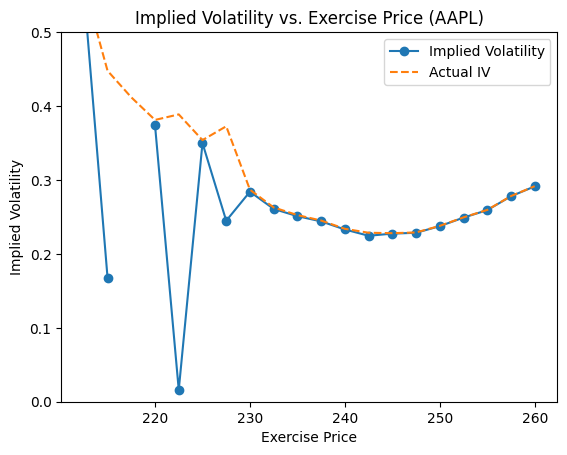

In [133]:
impl_vol_AAPL_wk = []
T_option = 6/365
r = rfrate(T_option)/100
S0 = 236.85
print(r)
for i in range(0, len(AAPL_calls_17_01)):
    E = AAPL_calls_17_01['Strike'][i]
    C_true = AAPL_calls_17_01['Last'][i]

    implied_volatility = newtons_method_volatility(S0, E, r, T_option, C_true)
    impl_vol_AAPL_wk.append(implied_volatility)
strike = np.array(AAPL_calls_17_01['Strike'])
impl_vol_AAPL_wk = np.array(impl_vol_AAPL_wk)
#replace large values with nan
impl_vol_AAPL_wk[impl_vol_AAPL_wk > 1] = np.nan
impl_vol_AAPL_wk[impl_vol_AAPL_wk < 0] = np.nan
#print(strike)
#print(impl_vol_AAPL)
plt.plot(strike, impl_vol_AAPL_wk, 'o-', label='Implied Volatility')
plt.plot(strike,AAPL_calls_17_01["IV"], '--', label='Actual IV')
#plt.axvline(x=S0, color='r', linestyle='--', label='Current Asset Price')
plt.ylim(0, 0.5)
plt.xlabel('Exercise Price')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility vs. Exercise Price (AAPL)')
plt.legend()
plt.show()

# for i in range(0, len(impl_vol_AAPL)):
#     if(impl_vol_AAPL[i] > 0.5 or impl_vol_AAPL[i] < 0):
#         print(AAPL_calls_17_01['Strike'][i], AAPL_calls_17_01['Last'][i])

0.04569984122408515


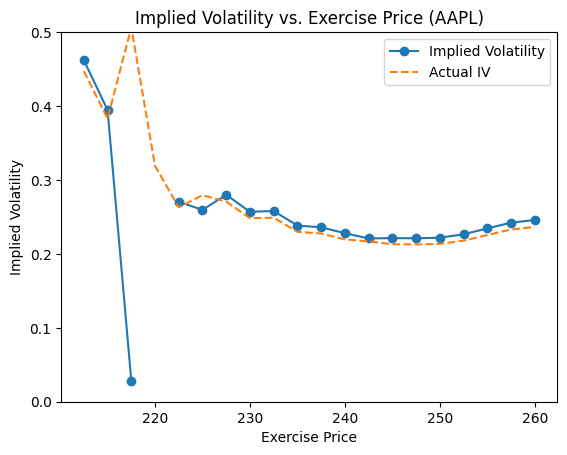

In [134]:
impl_vol_AAPL_2wk = []
T_option = 12/365
r = rfrate(T_option)/100
S0 = 236.85
print(r)
for i in range(0, len(AAPL_calls_24_01)):
    E = AAPL_calls_24_01['Strike'][i]
    C_true = AAPL_calls_24_01['Last'][i]

    implied_volatility = newtons_method_volatility(S0, E, r, T_option, C_true)
    impl_vol_AAPL_2wk.append(implied_volatility)
strike = np.array(AAPL_calls_24_01['Strike'])
impl_vol_AAPL_2wk = np.array(impl_vol_AAPL_2wk)
#replace large values with nan
impl_vol_AAPL_2wk[impl_vol_AAPL_2wk > 1] = np.nan
impl_vol_AAPL_2wk[impl_vol_AAPL_2wk < 0] = np.nan
#print(strike)
#print(impl_vol_AAPL)
plt.plot(strike, impl_vol_AAPL_2wk, 'o-', label='Implied Volatility')
plt.plot(strike,AAPL_calls_24_01["IV"], '--', label='Actual IV')
#plt.axvline(x=S0, color='r', linestyle='--', label='Current Asset Price')
plt.ylim(0, 0.5)
plt.xlabel('Exercise Price')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility vs. Exercise Price (AAPL)')
plt.legend()
plt.show()

0.042378572996520904


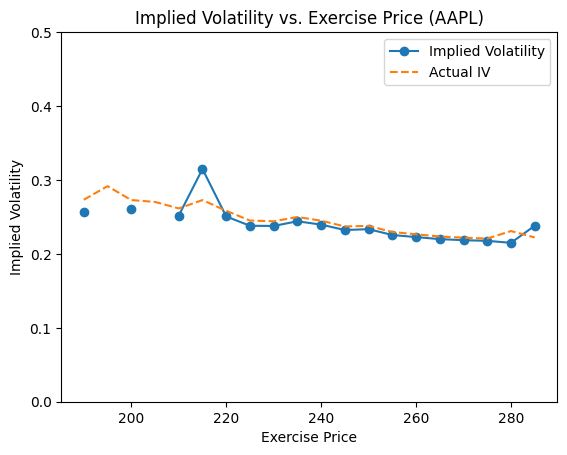

In [135]:
impl_vol_AAPL_3 = []
T_option = 279 / 365
r = rfrate(T_option) / 100
S0 = 236.85
print(r)
for i in range(0, len(AAPL_calls_17_10)):
    E = AAPL_calls_17_10['Strike'][i]
    C_true = AAPL_calls_17_10['Last'][i]

    implied_volatility = newtons_method_volatility(S0, E, r, T_option, C_true)
    impl_vol_AAPL_3.append(implied_volatility)
strike = np.array(AAPL_calls_17_10['Strike'])
impl_vol_AAPL_3 = np.array(impl_vol_AAPL_3)
#replace large values with nan
impl_vol_AAPL_3[impl_vol_AAPL_3 > 1] = np.nan
impl_vol_AAPL_3[impl_vol_AAPL_3 < 0] = np.nan
#print(strike)
#print(impl_vol_AAPL_3)
plt.plot(strike, impl_vol_AAPL_3, 'o-', label='Implied Volatility')
plt.plot(strike, AAPL_calls_17_10["IV"], '--', label='Actual IV')
#plt.axvline(x=S0, color='r', linestyle='--', label='Current Asset Price')
plt.ylim(0, 0.5)
plt.xlabel('Exercise Price')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility vs. Exercise Price (AAPL)')
plt.legend()
plt.show()

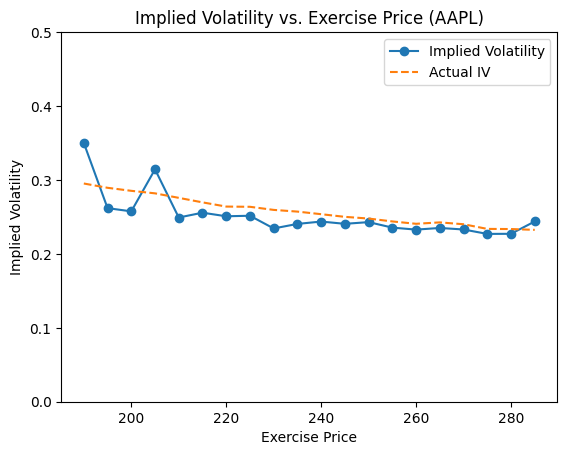

In [136]:
impl_vol_AAPL_4 = []
T_option = 523 / 365
r = rfrate(T_option) / 100
S0 = 236.85
#print(r)
for i in range(0, len(AAPL_calls_18_06_26)):
    E = AAPL_calls_18_06_26['Strike'][i]
    C_true = AAPL_calls_18_06_26['Last'][i]

    implied_volatility = newtons_method_volatility(S0, E, r, T_option, C_true)
    impl_vol_AAPL_4.append(implied_volatility)

strike = np.array(AAPL_calls_18_06_26['Strike'])
impl_vol_AAPL_4 = np.array(impl_vol_AAPL_4)
#replace large values with nan
impl_vol_AAPL_4[impl_vol_AAPL_4 > 1] = np.nan
impl_vol_AAPL_4[impl_vol_AAPL_4 < 0] = np.nan
#print(strike)
#print(impl_vol_AAPL_4)
plt.plot(strike, impl_vol_AAPL_4, 'o-', label='Implied Volatility')
plt.plot(strike, AAPL_calls_18_06_26["IV"], '--', label='Actual IV')
#plt.axvline(x=S0, color='r', linestyle='--', label='Current Asset Price')
plt.ylim(0, 0.5)
plt.xlabel('Exercise Price')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility vs. Exercise Price (AAPL)')
plt.legend()
plt.show()

#### 1c)

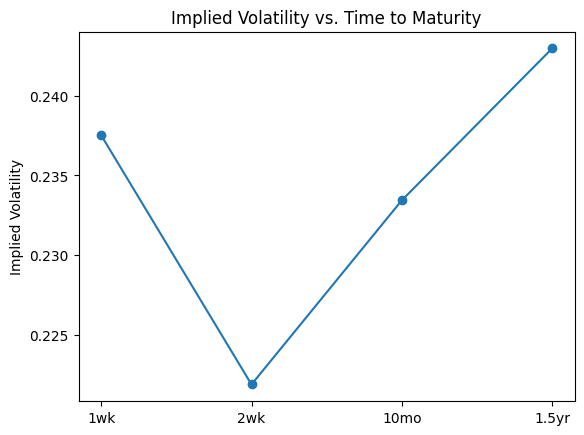

In [137]:
vol_4 = impl_vol_AAPL_4[AAPL_calls_18_06_26[AAPL_calls_18_06_26['Strike'] == 250].index]
vol_3 = impl_vol_AAPL_3[AAPL_calls_17_10[AAPL_calls_17_10['Strike'] == 250].index]
vol_2 = impl_vol_AAPL_2wk[AAPL_calls_24_01[AAPL_calls_24_01['Strike'] == 250].index]
vol_1 = impl_vol_AAPL_wk[AAPL_calls_17_01[AAPL_calls_17_01['Strike'] == 250].index]

plt.plot([1,2,3,4],[vol_1,vol_2,vol_3,vol_4], 'o-')
plt.xticks([1,2,3,4],['1wk','2wk','10mo','1.5yr'])
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility vs. Time to Maturity')
plt.show()


From the plot above, we can see that the implied volatility has a humped shape, with the highest value at 1.5 years and the lowest at 2 weeks. This implies that there is short-term uncertainty regarding `$AAPL`, followed by a stabilization period and topped off with more uncertainty, possibly due to the long-term nature of the option.

## Exercise 2: Binomial method

In [138]:
### Parameters ###
# American Put Option
S0 = 9
T = 1
r = 0.06
sigma = 0.3
E = 10
##################

In [139]:
def binomial_method_american_put(S0, E, r, T, sigma, M):
    """
    Calculate the value of an American put option using the binomial method.
    :param S0: initial asset price
    :param E: exercise price
    :param r: interest rate
    :param T: time to maturity
    :param sigma: volatility
    :param M: number of time steps
    :return: option value
    """
    dt = T / M
    u = np.exp(sigma * np.sqrt(dt) + (r-0.5*sigma**2) * dt)
    d = np.exp(-sigma * np.sqrt(dt) + (r-0.5*sigma**2) * dt)
    #p = (np.exp(r * dt) - d) / (u - d)
    p = 0.5

    # Compute stock price tree
    dpowers = d ** np.arange(start=M, stop=-1, step=-1)
    upowers = u ** np.arange(start=0, stop=M + 1, step=1)
    S = S0 * dpowers * upowers

    # Initialize option payoff at maturity
    W = np.maximum(E - S, 0)
    exercise_boundary = []
    # Perform backward induction
    for i in range(M, 0, -1):
        Si = S0 * dpowers[M - i + 1:M + 1] * upowers[:i]
        continuation_value = np.exp(-r * dt) * (p * W[1:i + 1] + (1 - p) * W[:i])
        exercise_value = E - Si
        # Update option value with early exercise consideration
        W = np.maximum(exercise_value, continuation_value)

        # Determine the exercise boundary (maximum stock price where early exercise occurs)
        boundary_price = np.max(Si[exercise_value > continuation_value]) if np.any(exercise_value > continuation_value) else np.nan
        exercise_boundary.append(boundary_price)

    return [W[0], exercise_boundary]

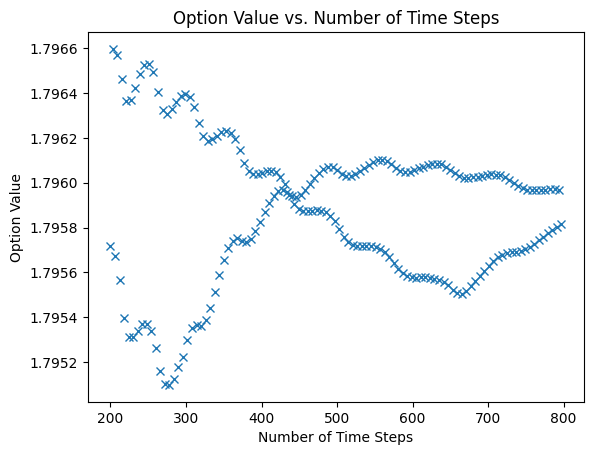

In [140]:
#Fig 18.1
ms = np.arange(200,800,3)
S0 = 9
T = 3
r = 0.06
sigma = 0.3
E = 10
put_values = []
for m in ms:
    put_values.append(binomial_method_american_put(S0, E, r, T, sigma, m)[0])
plt.plot(ms, put_values, 'x')
plt.xlabel('Number of Time Steps')
plt.ylabel('Option Value')
plt.title('Option Value vs. Number of Time Steps')
plt.show()
#print(put_values)

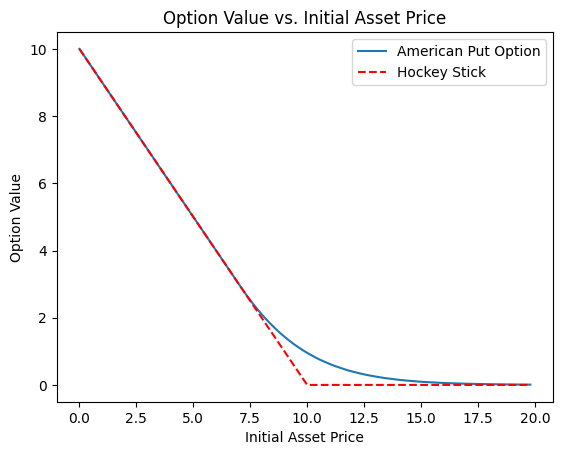

In [141]:
#Fig 18.3
T = 1
r = 0.06
sigma = 0.3
E = 10

M = 100
S0s = np.arange(0, 20, 0.2)

put_values = []
for S0 in S0s:
    put_values.append(binomial_method_american_put(S0, E, r, T, sigma, M)[0])
hockey = np.maximum(E-S0s,0)
# print(put_values)

plt.plot(S0s, put_values, '-', label = 'American Put Option')
plt.plot(S0s, hockey, 'r--', label='Hockey Stick')
plt.xlabel('Initial Asset Price')
plt.ylabel('Option Value')
plt.title('Option Value vs. Initial Asset Price')
plt.legend()
plt.show()

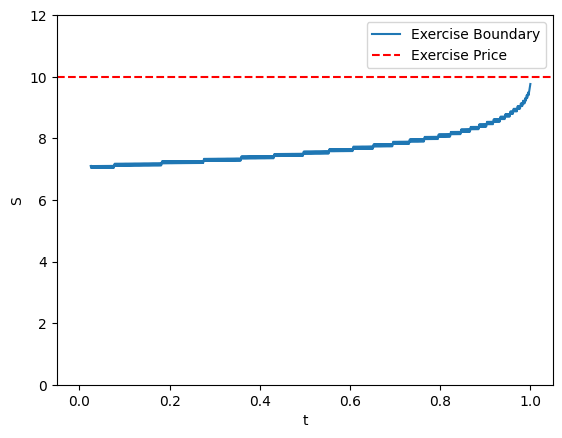

In [142]:
# Fig 18.4
S0=9
T = 1
r = 0.06
sigma = 0.3
E = 10
M = 1000
x = binomial_method_american_put(S0, E, r, T, sigma, M)
boundary = x[1][::-1]
#print(boundary)
plt.plot(np.linspace(0, T , M), boundary, linestyle='-',label='Exercise Boundary')
plt.ylim(0, 12)
plt.axline((0, E), slope=0, color='r', linestyle='--', label='Exercise Price')
plt.xlabel('t')
plt.ylabel('S')
plt.legend()
plt.show()

#### 2b)
Compute the time-zero value of a corresponding Bermudan put option, respectively, with 3, 6, 12 and 36 equally spaced early-exercise dates. Compared with American options in Question (2.a), what are your findings ?

In [143]:
def binomial_method_bermudan_put(S0, E, r, T, sigma, M, num_exercise_dates = 3 ):
    """
    Calculate the value of a Bermudan put option using the binomial method.
    :param S0: initial asset price
    :param E: exercise price
    :param r: interest rate
    :param T: time to maturity
    :param sigma: volatility
    :param M: number of time steps
    :param num_exercise_dates: number of equally spaced early-exercise dates
    :return: option value and exercise boundary
    """
    dt = T / M
    u = np.exp(sigma * np.sqrt(dt) + (r - 0.5 * sigma ** 2) * dt)
    d = np.exp(-sigma * np.sqrt(dt) + (r - 0.5 * sigma ** 2) * dt)
    p = (np.exp(r * dt) - d) / (u - d)

    dpowers = d ** np.arange(start=M, stop=-1, step=-1)
    upowers = u ** np.arange(start=0, stop=M + 1, step=1)
    S = S0 * dpowers * upowers

    W = np.maximum(E - S, 0)
    exercise_boundary = []

    exercise_steps = np.linspace(0, M, num_exercise_dates, dtype=int)

    for i in range(M, 0, -1):
        Si = S0 * dpowers[M - i + 1:M + 1] * upowers[:i]
        continuation_value = np.exp(-r * dt) * (p * W[1:i + 1] + (1 - p) * W[:i])

        if i in exercise_steps:
            exercise_value = E - Si
            W = np.maximum(exercise_value, continuation_value)

            boundary_price = np.max(Si[exercise_value > continuation_value]) if np.any(exercise_value > continuation_value) else np.nan
            exercise_boundary.append(boundary_price)
        else:
            W = continuation_value

    return [W[0], exercise_boundary]

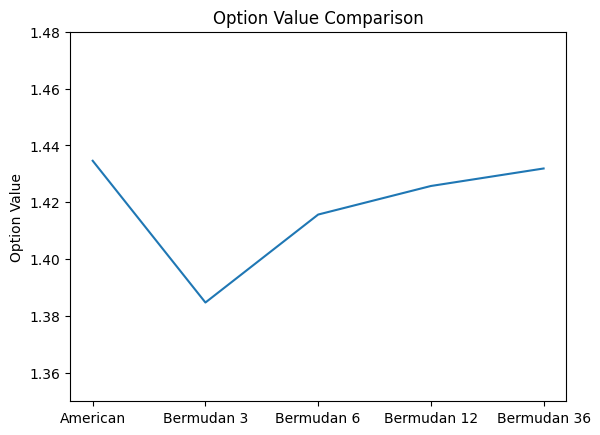

In [144]:
S0=9
T = 1
r = 0.06
sigma = 0.3
E = 10
M = 1000

american_put = binomial_method_american_put(S0, E, r, T, sigma, M)[0]
bermudan_put_3 = binomial_method_bermudan_put(S0, E, r, T, sigma, M, num_exercise_dates=3)[0]
bermudan_put_6 = binomial_method_bermudan_put(S0, E, r, T, sigma, M, num_exercise_dates=6)[0]
bermudan_put_12 = binomial_method_bermudan_put(S0, E, r, T, sigma, M, num_exercise_dates=12)[0]
bermudan_put_36 = binomial_method_bermudan_put(S0, E, r, T, sigma, M, num_exercise_dates=36)[0]

plt.plot([american_put,bermudan_put_3,bermudan_put_6,bermudan_put_12,bermudan_put_36])
plt.xticks([0,1,2,3,4],['American','Bermudan 3','Bermudan 6','Bermudan 12','Bermudan 36'])
plt.ylabel('Option Value')
plt.title('Option Value Comparison')
plt.ylim(1.35,1.48)
plt.show()



Compared with the American put, the Bermudan options are generally cheaper, with the value increasing with the number of exercise dates. This is because the Bermudan option has more flexibility to exercise, which is more valuable to the option holder. The American put option is the most expensive as it allows the holder to exercise at any time before the expiration date.

#### 2c)

In [145]:
import random
def binomial_method_shout_put(S0, E, r, T, sigma, M, num_simulations=1000):
    """
    Calculate the value of a shout put option using the binomial method with multiple shouting times.
    :param S0: initial asset price
    :param E: exercise price
    :param r: interest rate
    :param T: time to maturity
    :param sigma: volatility
    :param M: number of time steps
    :param num_simulations: number of simulations to average over.
    :return: estimated option value ( doing some Monte Carlo kinda stuff )
    """
    dt = T / M
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # Store the option values from multiple simulations
    option_values = []

    for _ in range(num_simulations):
        # Compute stock price tree
        dpowers = d ** np.arange(start=M, stop=-1, step=-1)
        upowers = u ** np.arange(start=0, stop=M + 1, step=1)
        S = S0 * dpowers * upowers

        # Initialize option payoff at maturity
        W = np.maximum(E - S, 0)

        # Select a random shouting time
        shouting_time = random.randint(0, M)

        # Perform backward induction
        for i in range(M, 0, -1):
            Si = S0 * dpowers[M - i + 1:M + 1] * upowers[:i]
            continuation_value = np.exp(-r * dt) * (p * W[1:i + 1] + (1 - p) * W[:i])

            if i == shouting_time:  # If the current step is the shouting time
                W = np.maximum(W[:i], continuation_value)
            else:
                exercise_value = np.maximum(E - Si, 0)
                W = np.maximum(exercise_value, continuation_value)

        # Store the option value from this simulation
        option_values.append(W[0])

    # Return the average option value
    return np.mean(option_values)


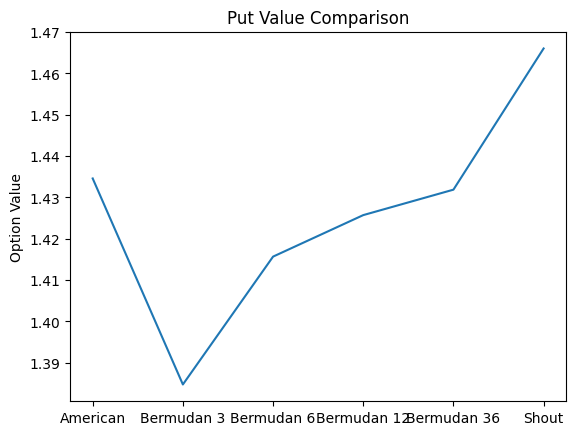

In [146]:
S0=9
T = 1
r = 0.06
sigma = 0.3
E = 10
M = 1000

american_put = binomial_method_american_put(S0, E, r, T, sigma, M)[0]
bermudan_put_3 = binomial_method_bermudan_put(S0, E, r, T, sigma, M, num_exercise_dates=3)[0]
bermudan_put_6 = binomial_method_bermudan_put(S0, E, r, T, sigma, M, num_exercise_dates=6)[0]
bermudan_put_12 = binomial_method_bermudan_put(S0, E, r, T, sigma, M, num_exercise_dates=12)[0]
bermudan_put_36 = binomial_method_bermudan_put(S0, E, r, T, sigma, M, num_exercise_dates=36)[0]
shout_put = binomial_method_shout_put(S0, E, r, T, sigma, M, num_simulations=1000)

plt.plot([american_put,bermudan_put_3,bermudan_put_6,bermudan_put_12,bermudan_put_36, shout_put])
plt.xticks([0,1,2,3,4,5],['American','Bermudan 3','Bermudan 6','Bermudan 12','Bermudan 36', 'Shout'])
plt.ylabel('Option Value')
plt.title('Put Value Comparison')
# plt.ylim(1.35,1.48)
plt.show()


As far as the options are concerned, we conclude that the shoult is the most expensive of all, which could be from the fact that it has the most flexibility to exercise. The Bermudan options are generally cheaper than the American put, with the value increasing with the number of exercise dates. The American put option is the second most expensive as it allows the holder to exercise at any time before the expiration date. The shout put is the most expensive as the holder can secure a better price without actually exercising, making the possible wins much bigger and the 'losses' smaller.

## Exercise 3: Monte Carlo Simulation

a) Solve:
- value an arithmetic average Asian put option with payoff $$\max(E − \frac{1}{n} \sum^n_{i=1} S(t_i), 0)$$ (here n = 52).
- value a fixed strike lookback put option with payoff $max(E − S^{min}, 0)$

In [147]:
### Parameters ###
T = 1
S0 = 1
E = 1.2
r = 0.05
sigma = 0.3
# n = 52, T = 1 year
###################

In [148]:
def simulate_asset_path(S0, r, sigma, T, n):
    """
    Simulate an asset price path using the Black-Scholes model.
    :param S0: initial asset price
    :param r: interest rate
    :param sigma: volatility
    :param T: time to maturity
    :param n: number of time steps
    :return: asset price path
    """
    dt = T / n
    W = np.random.normal(0, np.sqrt(dt), n)
    t = np.linspace(0, T, n)
    S = S0 * np.exp(np.cumsum((r - 0.5 * sigma ** 2) * dt + sigma * W))
    return S

def asian_option_payoff(S, E):
    """
    Calculate the payoff of an arithmetic average Asian put option.
    :param S: asset price path
    :param E: exercise price
    :return: option payoff
    """
    return np.maximum(E - np.mean(S), 0)

def lookback_option_payoff(S, E):
    """
    Calculate the payoff of a fixed strike lookback put option.
    :param S: asset price path
    :param E: exercise price
    :return: option payoff
    """
    return np.maximum(E - np.min(S), 0)

In [149]:
M = 20001

asian_option_values = []
lookback_option_values = []

for i in range(M):
    S = simulate_asset_path(S0, r, sigma, T, 52)
    asian_option_values.append(asian_option_payoff(S, E))
    lookback_option_values.append(lookback_option_payoff(S, E))
    if [50, 100, 500 ,1000,2000,5000,10000,20000].__contains__(i):
        asian_option_value = np.mean(asian_option_values )* np.exp(-r * T)
        lookback_option_value = np.mean(lookback_option_values)* np.exp(-r * T)

        print(f'Asian Option Value ({i} Monte Carlo Trials): {round(asian_option_value,4)}')
        print(f'Lookback Option Value ({i} Monte Carlo Trials): {round(lookback_option_value,4)}')
        print("---------------------------------------------------------")

print(asian_option_value,lookback_option_value)

Asian Option Value (50 Monte Carlo Trials): 0.2026
Lookback Option Value (50 Monte Carlo Trials): 0.3824
---------------------------------------------------------
Asian Option Value (100 Monte Carlo Trials): 0.1895
Lookback Option Value (100 Monte Carlo Trials): 0.361
---------------------------------------------------------
Asian Option Value (500 Monte Carlo Trials): 0.1898
Lookback Option Value (500 Monte Carlo Trials): 0.3662
---------------------------------------------------------
Asian Option Value (1000 Monte Carlo Trials): 0.1865
Lookback Option Value (1000 Monte Carlo Trials): 0.3635
---------------------------------------------------------
Asian Option Value (2000 Monte Carlo Trials): 0.1855
Lookback Option Value (2000 Monte Carlo Trials): 0.3596
---------------------------------------------------------
Asian Option Value (5000 Monte Carlo Trials): 0.1876
Lookback Option Value (5000 Monte Carlo Trials): 0.3606
---------------------------------------------------------
Asian O

b) Employ a variance reduction technique to approximate their Delta at time t = 0 and investigate how the numerical error varies over the number of asset paths.

I will be using the _antithetic variates_ method as a variance reduction technique.

In [150]:
def asian_option_payoff(S, E):
    return np.maximum(np.mean(S, axis=0) - E, 0)
def lookback_option_payoff(S, E):
    return np.maximum(np.max(S, axis=0) - E, 0)

def antithetic_variates_delta(S0, r, sigma, T, E, n, M, epsilon, payoff_function):
    """
    Estimate the delta of an option using the antithetic variates method.
    :param S0: initial asset price
    :param r: interest rate
    :param sigma: volatility
    :param T: time to maturity
    :param E: exercise price
    :param n: number monte carlo paths
    :param M: number of time steps
    :param epsilon: offset for delta estimation
    :param payoff_function: option payoff function
    :return: delta estimate and standard deviation
    """
    dt = T/M
    Z = np.random.normal(0, 1, (M, n))  # standard normal random numbers
    mZ = -Z  # antithetic counterpart

    # Compute asset price paths (normal and antithetic)
    S = S0 * np.exp(np.cumsum((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z, axis=0))
    mS = S0 * np.exp(np.cumsum((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * mZ, axis=0))

    # Compute asset price paths with epsilon offset
    eS = (S0 + epsilon) * np.exp(np.cumsum((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(T / n) * Z, axis=0))
    emS = (S0 + epsilon) * np.exp(np.cumsum((r - 0.5 * sigma ** 2) * dt + sigma        * np.sqrt(T / n) * mZ, axis=0))

    # compute option payoffs
    payoff = payoff_function(S, E)
    mpayoff = payoff_function(mS, E)
    epayoff = payoff_function(eS, E)
    empayoff = payoff_function(emS, E)

    # Compute delta estimate per path using both the Monte Carlo method and antithetic variates
    deltas = (payoff - epayoff + mpayoff - empayoff) / (2 * epsilon)

    # Estimate delta and its standard deviation
    delta = np.mean(deltas)
    delta_std = np.std(deltas)

    return delta, delta_std

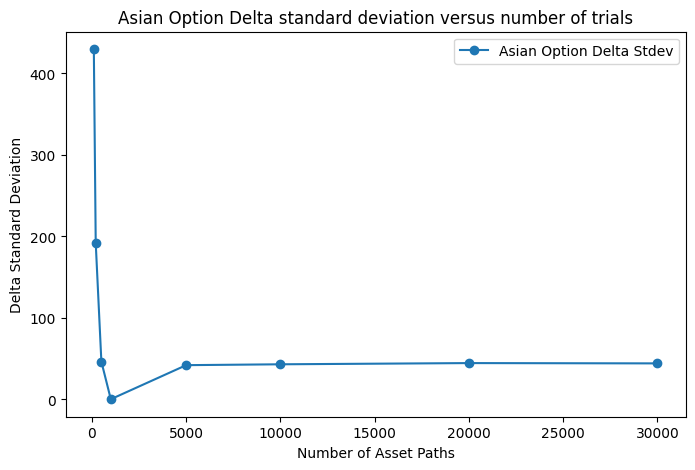

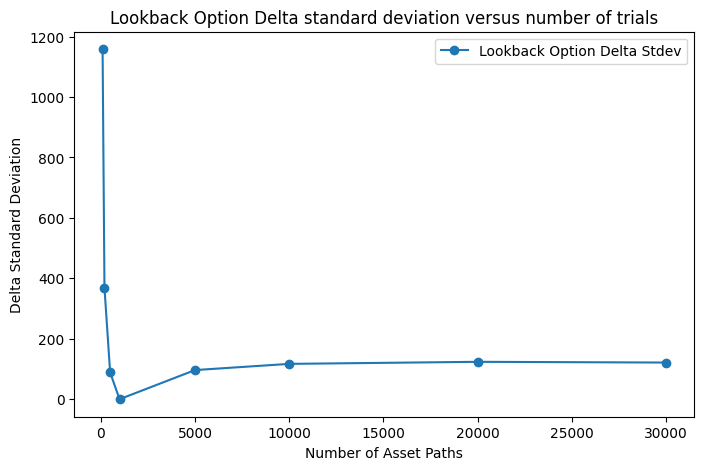

In [151]:
T = 1
S0 = 1
E = 1.2
r = 0.05
sigma = 0.3
ns = [100, 200, 500, 1000, 5000, 10000, 20000, 30_000]
M = 1000
epsilon = 0.001

asian_deltas = []
lookback_deltas = []


for n in ns:
    delta_asian, stdev_asian = antithetic_variates_delta(S0, r, sigma, T, E, n, M, epsilon, asian_option_payoff)
    delta_lookback, stdev_lookback = antithetic_variates_delta(S0, r, sigma, T, E, n, M, epsilon, lookback_option_payoff)

    asian_deltas.append(stdev_asian)
    lookback_deltas.append(stdev_lookback)

# Plot for Asian Option Delta Standard Deviation
plt.figure(figsize=(8, 5))
plt.plot(ns, asian_deltas, 'o-', label='Asian Option Delta Stdev')
plt.xlabel('Number of Asset Paths')
plt.ylabel('Delta Standard Deviation')
plt.title('Asian Option Delta standard deviation versus number of trials')
plt.legend()
plt.show()

# Plot for Lookback Option Delta Standard Deviation
plt.figure(figsize=(8, 5))
plt.plot(ns, lookback_deltas, 'o-', label='Lookback Option Delta Stdev')
plt.xlabel('Number of Asset Paths')
plt.ylabel('Delta Standard Deviation')
plt.title('Lookback Option Delta standard deviation versus number of trials')
plt.legend()
plt.show()

## Exercise 4: Finite Difference Methods